FSSC Science Tools
=========================
Fermi LAT Likelihood Analysis: Overview, Livetime, Exposure and pyLike
-------------------------
*Jeremy S. Perkins, NASA/GSFC*

**Goal:** *Understand and Complete a simple likelihood analysis*

Goals of Any Analysis
============================
* Test for presence of a source, measure its position in the sky
* Extract fluxes of sources of interest. Measure flux vs. time (“lightcurve”) to test for variability.
* Measure spectra of sources
    * Parameters of fitted spectral type, e.g. index of power-law, energy of exponential cut-off, or “super”-exponential cutoff (pulsars)
    * Flux as function of energy (“flux in bands”) 


Last time we saw...
==========================
* Maximum likelihood is framework/cookbook for estimation and hypothesis testing
* To use, must produce accurate model of data (the rest is derived by following the cookbook)
* Some portions of model are of interest to us
* Others are not
    * Background sources
    * Observational response
* Must be mindful of systematic errors 

ScienceTools
=======================
* MLE and hypothesis testing is implemented for Fermi LAT data using ScienceTools.
* Data selection and binning into channels.
* Assists in producing of high-level sky model consisting of gamma-ray sources.
* Transforms sky model into low-level Poisson model for each channel (observational response).
* Estimation of parameters through optimization (“minimization”) using log-likelihood.
* Calculation of upper limits.

Data Exploration
==========================
* Photon files - list of photons in FITS format
    * Browser: http://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi
    * All-sky: https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/photon/
    * All-sky spacecraft file: https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/mission/spacecraft/
* Events reconstructed @SLAC and consist of:
    * Estimate of direction of origin
    * Estimate of the energy
    * “Probability” of being gamma ray (event classification)
    * Zenith angle, conversion point (front or back), detection time, ...

Data Before Cuts (4.8 years)
=============================

![cmap_nocuts](images/cmap_nocuts.png)

* Data set that we would like to analyze (using ML).
* Or in fact, it is a simplification.. the energy and time dependence are not shown! 

Data Set with Sensible Cuts
=============================
Appy Selection
* Zenith cut to remove photons from the Earth (∠Zn < 90deg)
* Photon class to select best reconstructed and lowest background (P8R2_Clean_V6)

![fullskywithcut](images/cmap_z100.png)

* Some part of the “background” can be removed: “cuts”. 
* Makes it easier to model (remaining) data.
* Rest cannot easily be separated: must be modeled. 

Region of Interest
=========================

![fullskyannote](images/cmap_z100_wCirc.png)

* Don’t have to analyze full sky at once! Select a region of interest (ROI) around source.
* Larger: better measure background (>TS)
* Smaller: faster & lower background subtraction systematics (maybe!)
* About 20 degrees is good compromise.

### gtselect (filter in python) 

* Data are already filtered when you get them from the FSSC 
* gtselect is used to do more filtering
* inputs include a list of event files


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits

In [3]:
rc('font', **{'size'   : 22})

In [4]:
from gt_apps import filter

In [5]:
filter.pars()

' infile= outfile= ra="INDEF" dec="INDEF" rad="INDEF" tmin="INDEF" tmax="INDEF" emin=30.0 emax=300000.0 zmin=0.0 zmax=180.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"'

In [34]:
filter['infile'] = '@../data/events.txt'
filter['outfile'] = '../data/3C279_filtered.fits'
filter['ra'] = 194.047
filter['dec'] = -5.78931
filter['rad'] = 15
filter['tmin'] = 239557417
filter['tmax'] = 255398400
filter['emin'] = 100
filter['emax'] = 100000
filter['zmax'] = 90
filter['evclass'] = 128
filter['evtype'] = 3

In [35]:
filter.run()

time -p gtselect infile=@../data/events.txt outfile=../data/3C279_filtered.fits ra=194.047 dec=-5.78931 rad=15.0 tmin=239557417.0 tmax=255398400.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"


Done.
real 4.89
user 2.26
sys 0.58


### maketime (or gtmaketime)

* This program marks times of bad data 
* Can also do complex filtering using it
* Check out the FSSC site for more details.

In [36]:
from gt_apps import maketime
maketime['evfile'] = '../data/3C279_filtered.fits'
maketime['outfile'] = '../data/3C279_mktime.fits'
maketime['scfile'] = '../data/SC00.fits'
maketime['filter'] = 'DATA_QUAL>0 && LAT_CONFIG==1'
maketime['apply_filter'] = 'yes'
maketime['roicut'] = 'yes'
maketime.run()

time -p gtmktime scfile=../data/SC00.fits sctable="SC_DATA" filter="DATA_QUAL>0 && LAT_CONFIG==1" roicut=yes evfile=../data/3C279_filtered.fits evtable="EVENTS" outfile="../data/3C279_mktime.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"


real 3.59
user 1.43
sys 0.75


### gtbin (or evtbin)

* Used to make counts maps (pictures) or bin the data in time and/or energy.
* We're going to use it to look at our ROI.

In [37]:
from gt_apps import evtbin

In [38]:
evtbin['evfile'] = '../data/3C279_mktime.fits'
evtbin['outfile'] = '../data/3C279_cmap.fits'
evtbin['algorithm'] = 'cmap'
evtbin['nxpix'] = 100
evtbin['nypix'] = 100
evtbin['binsz'] = 0.2
evtbin['coordsys'] = 'CEL'
evtbin['xref'] = 194.047
evtbin['yref'] = -5.78931
evtbin['axisrot'] = 0.0
evtbin['proj'] = 'CAR'

In [39]:
evtbin.run()

time -p gtbin evfile=../data/3C279_mktime.fits scfile=NONE outfile=../data/3C279_cmap.fits algorithm="cmap" ebinalg="LOG" emin=100.0 emax=100000.0 enumbins=20 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=100 nypix=100 binsz=0.2 coordsys="CEL" xref=194.047 yref=-5.78931 axisrot=0.0 rafield="RA" decfield="DEC" proj="CAR" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"


This is gtbin version HEAD
gtbin: WARNING: No spacecraft file: EXPOSURE keyword will be set equal to ontime.
real 0.52
user 0.30
sys 0.24


In [40]:
cmap_hdu = pyfits.open('../data/3C279_cmap.fits')

In [41]:
print cmap_hdu.info()

Filename: ../data/3C279_cmap.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     128   (100, 100)   int32   
  1  GTI           1 BinTableHDU     48   3514R x 2C   [D, D]   
None


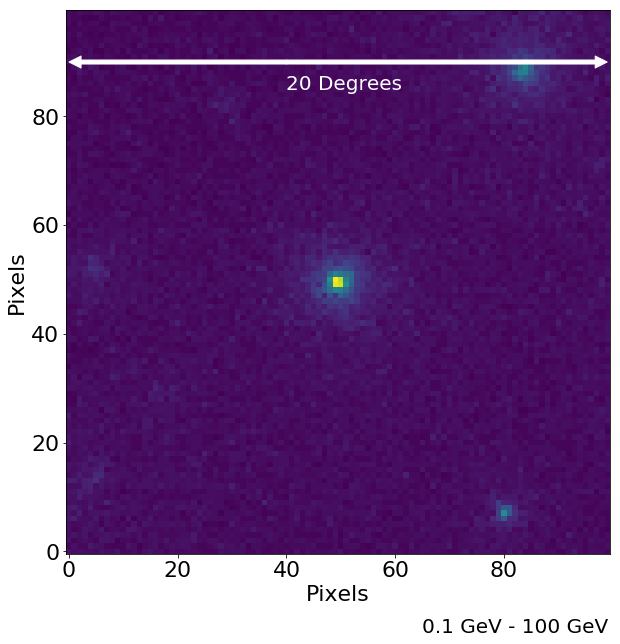

In [42]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(cmap_hdu[0].data,origin='lower')
plt.annotate(
    '', xy=(0, 90), xycoords = 'data',
    xytext = (40, 90), textcoords = 'data',
    arrowprops = {'facecolor':'white','edgecolor':'white'})
plt.annotate(
    '', xy=(99, 90), xycoords = 'data',
    xytext = (40, 90), textcoords = 'data',
    arrowprops = {'facecolor':'white','edgecolor':'white'})
plt.text(40, 85, '20 Degrees',fontsize=20,color='white')
plt.text(65,-15,"0.1 GeV - 100 GeV",fontsize=20)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

Channels of position and energy
====================================
 * Calculate the counts cube (counts map binned in energy) 
 * This is useful to see how our ROI changes with energy
 * (We'll also need this later in the analysis)
 * Notice that we used 'cmap' before and now we're using 'ccube'

In [43]:
evtbin['algorithm'] = 'CCUBE'
evtbin['evfile'] = '../data/3C279_mktime.fits'
evtbin['outfile'] = '../data/3C279_ccube.fits'
evtbin['nxpix'] = 100
evtbin['nypix'] = 100
evtbin['binsz'] = 0.2
evtbin['coordsys'] = 'CEL'
evtbin['xref'] = 194.047
evtbin['yref'] = -5.78931
evtbin['axisrot'] = 0.0
evtbin['proj'] = 'CAR'
evtbin['ebinalg'] = 'LOG'
evtbin['emin'] = 100
evtbin['emax'] = 100000
evtbin['enumbins'] = 20

In [44]:
evtbin.run()

time -p gtbin evfile=../data/3C279_mktime.fits scfile=NONE outfile=../data/3C279_ccube.fits algorithm="CCUBE" ebinalg="LOG" emin=100.0 emax=100000.0 enumbins=20 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=100 nypix=100 binsz=0.2 coordsys="CEL" xref=194.047 yref=-5.78931 axisrot=0.0 rafield="RA" decfield="DEC" proj="CAR" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"


This is gtbin version HEAD
gtbin: WARNING: No spacecraft file: EXPOSURE keyword will be set equal to ontime.
real 0.87
user 0.36
sys 0.20


In [45]:
ccube_hdu = pyfits.open('../data/3C279_ccube.fits')

### Why did we pick the binning we did?
* Response functions are minimally parameterized in the inclination angle (theta) and energy
    * Bin or step sizes used in exposure calculations should consider how quickly the efficiency changes in space or energy
        * At least 10 bins per decade in energy to avoid errors in estimation where the effective area changes rapidly
        * No single, strict recommendation on spatial binning
            * 1 deg default sufficient for making maps
            * The Binned likelihood is matched to data binning
    * gtexposure invokes a spectral assumption - this has a noticeable impact  
        * Remember that both the efficiency and angular reconstruction depend on energy

In [46]:
ccube_hdu.info()

Filename: ../data/3C279_ccube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     134   (100, 100, 20)   int32   
  1  EBOUNDS       1 BinTableHDU     43   20R x 3C   [I, 1E, 1E]   
  2  GTI           1 BinTableHDU     49   3514R x 2C   [D, D]   


In [47]:
import time
from IPython.display import display,clear_output

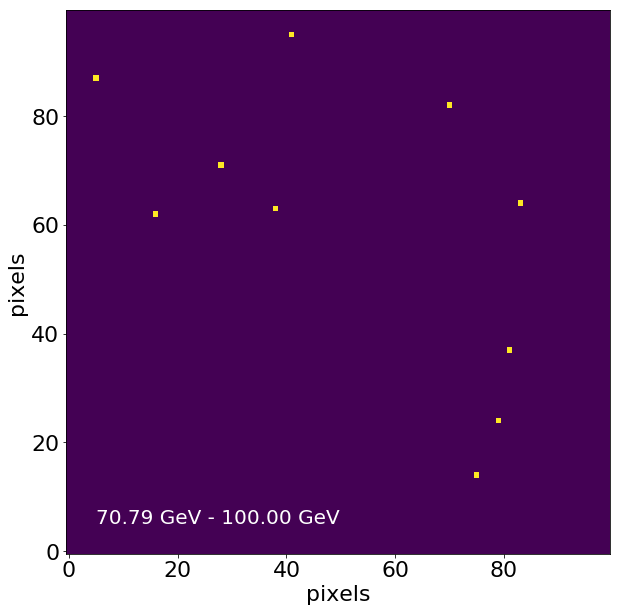

In [48]:
f, ax = plt.subplots(figsize=(10, 10))
for i, ccube in enumerate(ccube_hdu[0].data):
    time.sleep(0.2)
    plt.imshow(ccube,origin='lower')
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    label =  "{:.2f} GeV - {:.2f} GeV".format(ccube_hdu[1].data['E_MIN'][i]/1e6,
                                             ccube_hdu[1].data['E_MAX'][i]/1e6)
    plt.text(5,5,label,fontsize=20, color='white')
    clear_output(wait=True)
    display(f)
    ax.cla()
    
plt.close()

* Analyze events in channels of position and energy...
* ... as we are interested in spatial and energy dependence of sources
* ... best sensitivity achieved by using all information possible (as long as it can be modeled accurately!)

At higher energies there are fewer photon,
    1. Sources look less spread out (narrower PSF),
    2. There is less background.
At lower energies there are lots of photons,
    1. Sources look more spread out (broader PSF) and are more confused
    2. There is a lot of background!
Sources are most clearly detectable somewhere in the middle.

Calculating Livetime and Exposure
---------------------------------
* Calculating the exposure is a two-step process
    * **Livetime:** formally the time when the detector is available to collect data
        * For analysis, we additionally require good data quality and select to remove high background
        * The LAT has a large FoV with varying response: need to know when and where
    * **Exposure:** for practical purposes, the number that converts counts to photon flux
        * Apply expected photon detection efficiency and angular resolution
            * Depends on the event selection
            * Depends on the direction of the photon relative to the instrument boresight and energy

In [49]:
from gt_apps import expCube

In [50]:
expCube.pars()

' evfile="../data/3C279_mktime.fits" evtable="EVENTS" scfile=../data/SC00.fits sctable="SC_DATA" outfile=../data/3C279_ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"'

In [51]:
expCube['evfile'] = '../data/3C279_mktime.fits'
expCube['scfile'] = '../data/SC00.fits'
expCube['outfile'] = '../data/3C279_ltcube.fits'
expCube['dcostheta'] = 0.025
expCube['binsz'] = 1.0

In [52]:
expCube.run()

time -p gtltcube evfile="../data/3C279_mktime.fits" evtable="EVENTS" scfile=../data/SC00.fits sctable="SC_DATA" outfile=../data/3C279_ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"


Working on file ../data/SC00.fits
.....................!
real 949.09
user 942.40
sys 1.14


This takes a while to run...

Let's talk about what it's doing while we're waiting.

Data Collection Profile
========================

![2orbit](images/2orbit.png)

![LatPolar_Vela](images/LatPolar_Vela.jpg)


![cmapanimation](images/map_z100_ss20noX.gif)

* Modeling must also account for the “observing profile”.
* Rate of γ rays from source depends on its (constantly changing) position in the field of view of the LAT. 

Observational Profile
===========================
* Pointing records from spacecraft file - every 30 seconds
* RA & Dec of LAT pointing direction, the z-axis
    * (and of x-axis for phi dependence)
* Observation mode - sky survey, pointed
* See the Data Exploration Notebook for a description 

### Livetime
* Sum up time spent in the field of view for each position in the celestial sky
    * Inputs are the photon and spacecraft files
    * Options are pixel size and step size for the instrument angles
    * Output is a livetime ‘cube’
    * Respects time-based selection cuts made with gtmktime (GTIs)
* **Livetime and Maximum Zenith Angle**
    * gtltcube knowns about the field of view and the spacecraft pointing (via the spacecraft file) and can make exposure corrections related to this corrodinate systems.
    * If you are doing an all-sky analysis or non-stantdard zenith cut, gtltcube can make a correction for the exposure loss from a zenith angle cut in gtselect.
        * **note:** this assumes perfect reconstruction
    * **If you're doing a basic source analysis and using the standard ROI cut you don't need to do this.**
    
* Example: if you use *zmax = 100* in *gtselect* and set *ROIcut = no* in *gtmktime* then you **must** use *zmax=100* in *gtltcube*.

'Exposure' vs Time
=============================

![exposure](images/exposure.png)

* Instantaneous exposure for some source.
* Systematics may be present on short timescales or in some temporal analyses.
* See http://fermi.gsfc.nasa.gov/ssc/data/analysis/LAT_caveats_temporal.html

In [53]:
ltcube_hdu = pyfits.open('../data/3C279_ltcube.fits')

In [54]:
print ltcube_hdu.info()

Filename: ../data/3C279_ltcube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  EXPOSURE      1 BinTableHDU     59   49152R x 3C   [40E, E, E]   
  2  WEIGHTED_EXPOSURE    1 BinTableHDU     59   49152R x 3C   [40E, E, E]   
  3  CTHETABOUNDS    1 BinTableHDU     33   40R x 2C   [E, E]   
  4  GTI           1 BinTableHDU     46   3514R x 2C   [D, D]   
None


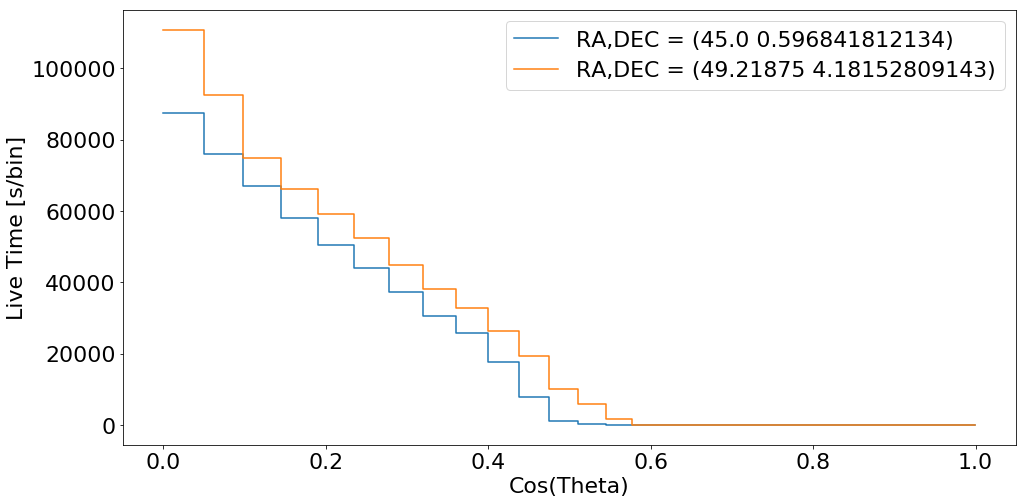

In [55]:
plt.figure(figsize=(16,8))
label_txt = "RA,DEC = ({} {})".format(ltcube_hdu[1].data.field('ra')[0],
                                      ltcube_hdu[1].data.field('dec')[0])

plt.step(ltcube_hdu[3].data.field('CTHETA_MIN'),
         ltcube_hdu[1].data.field('cosbins')[0], label=label_txt)


label_txt = "RA,DEC = ({} {})".format(ltcube_hdu[1].data.field('ra')[20],
                                      ltcube_hdu[1].data.field('dec')[20])
plt.step(ltcube_hdu[3].data.field('CTHETA_MIN'),
         ltcube_hdu[1].data.field('cosbins')[20], label=label_txt)
plt.xlabel('Cos(Theta)')
plt.ylabel('Live Time [s/bin]')
plt.legend()
plt.show()

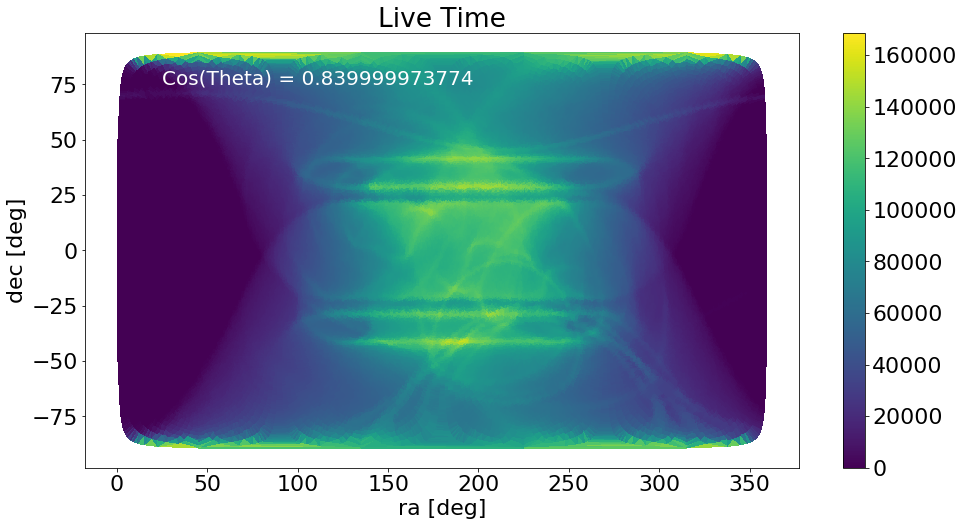

In [56]:
cosbin = 15
plt.figure(figsize=(16,8))
plt.tripcolor(np.array(ltcube_hdu[1].data.field('ra')),
               np.array(ltcube_hdu[1].data.field('dec')),
               np.array(ltcube_hdu[1].data.field('cosbins'))[:,cosbin])
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.title('Live Time')
label =  "Cos(Theta) = {}".format(np.array(ltcube_hdu[3].data.field('CTHETA_MIN')[cosbin]))
plt.text(25,75,label,fontsize=20, color='white')
plt.colorbar()
plt.show()

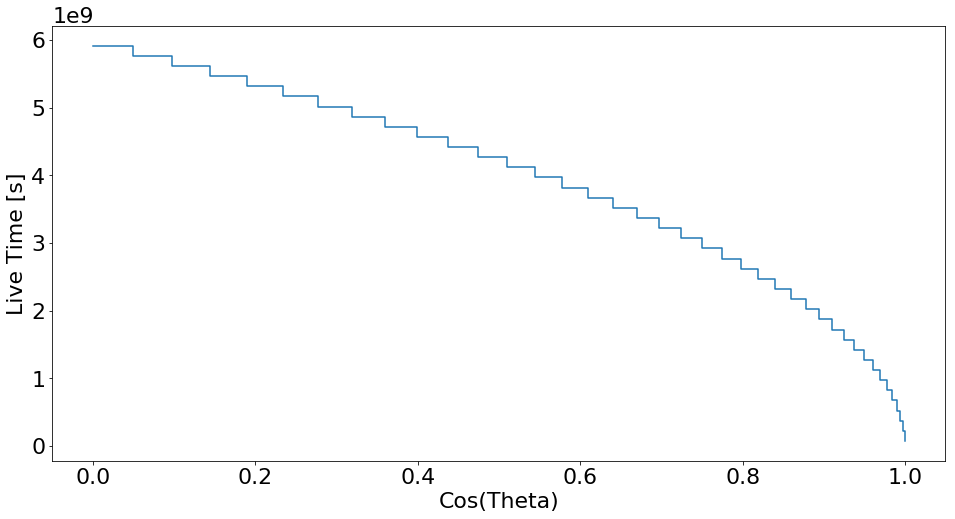

In [57]:
plt.figure(figsize=(16,8))
plt.step(ltcube_hdu[3].data.field('CTHETA_MIN'),
         np.sum(ltcube_hdu[1].data.field('cosbins'), axis=0))

plt.xlabel('Cos(Theta)')
plt.ylabel('Live Time [s]')
plt.show()


### Calculate the Exposure

Let's start the exposure calculation going and then we'll talk about what goes into that calculation.

In [58]:
from gt_apps import gtexpcube2
gtexpcube2['infile'] = '../data/3C279_ltcube.fits'
gtexpcube2['cmap'] = '../data/3C279_ccube.fits'
gtexpcube2['outfile'] = '../data/3C279_expcube.fits'
gtexpcube2['nxpix'] = 360
gtexpcube2['nypix'] = 180
gtexpcube2['binsz'] = 1.0
gtexpcube2['coordsys'] = 'CEL'
gtexpcube2['xref'] = 194.047
gtexpcube2['yref'] = -5.78931
gtexpcube2['axisrot'] = 0.0
gtexpcube2['proj'] = 'CAR'
gtexpcube2['ebinalg'] = 'LOG'
gtexpcube2['emin'] = 100
gtexpcube2['emax'] = 100000
gtexpcube2['enumbins'] = 20

In [59]:
ls ../data

3C279_ccube.fits     3C279_ltcube.fits  gll_iem_v06.fits@            SC00.fits
3C279_cmap.fits      3C279_mktime.fits  iso_P8R2_SOURCE_V6_v06.txt@
3C279_filtered.fits  events.txt         PH00.fits


In [60]:
gtexpcube2.run()

time -p gtexpcube2 infile=../data/3C279_ltcube.fits cmap=../data/3C279_ccube.fits outfile=../data/3C279_expcube.fits irfs="CALDB" evtype="INDEF" nxpix=360 nypix=180 binsz=1.0 coordsys="CEL" xref=194.047 yref=-5.78931 axisrot=0.0 proj="CAR" ebinalg="LOG" emin=100.0 emax=100000.0 enumbins=20 ebinfile="NONE" hpx_ordering_scheme="RING" hpx_order=6 bincalc="EDGE" ignorephi=no thmax=180.0 thmin=0.0 table="EXPOSURE" chatter=2 clobber=yes debug=no mode="ql"


Caught St13runtime_error at the top level: File not found: 


RuntimeError: gtexpcube2 execution failed

Instrument Response Functions
================================
* Effective Area - how the photon collecting area depends on energy and angle
* Point Spread Function (PSF) - how the reconstructed photon angles from a point source are distributed around the true direction in the sky
* Energy Dispersion - how reconstructed photon energy is distributed around the true energy - **often neglected in analysis but important for Pass 8 below ~100 MeV**
* IRF set must match event selection used in analysis, eg. “P8R2_SOURCE_V6” 

Effective Area (EA)
=============================

![EASlide](images/EA_P8R2_SOURCE_V6.png)

* Collecting area for events with TRUE energy E, and TRUE angles in spacecraft(θ,φ) 

More info: http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/index.html

or: http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm 


Point Spread Function
================================

![PSF](images/PSF_P8R2_SOURCE_V6.png)

* Point-spread function for events with TRUE energy E, and TRUE angles in spacecraft (θ,φ) 

More info: http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/index.html

or: http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm 

Energy Dispersion
================================

![energy dispersion](images/Edisp_P8R2_SOURCE_V6.png)

* Energy dispersion for events with TRUE energy E, and TRUE angles in spacecraft (θ,φ)

More info: http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/index.html

or: http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm 

Observational Response
===============================
![Observational Response](images/obs_resp.png)

Observational Response (what we've calculated so far)
==============================

Instantaneous Response = EA x PSF x ED

$$R_t(E, \hat{p},t) = A(E, \hat{p},t)
\times P(\hat{p},E,t) 
\times D(E,\hat{p},t)$$

Total Response

$$R(E, \vec{p}) = \int dt R_t(E, \vec{p},t)$$

Total 'Exposure' in units of cm<sup>2</sup>s

$$\int_0^\infty dE  \int _{4\pi} d\hat{p}\ R(E, \hat{p})
= \int_{t_0}^{t_1} dt A(E, \hat{p},t) = X(E,\hat{p})$$

Define average PSF and ED

$$R(E,\hat{p}, E, \hat{p}) = X(E,\hat{p}) \bar{P}(\hat{p},E) \bar{D}(E,\hat{p})$$

In [34]:
expcube_hdu = pyfits.open('../data/3C279_expcube.fits')

In [35]:
expcube_hdu.info()

Filename: ../data/3C279_expcube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   (360, 180, 21)   float32   
  1  ENERGIES      1 BinTableHDU     13   21R x 1C   [1D]   
  2  GTI           1 BinTableHDU     18   3514R x 2C   [D, D]   


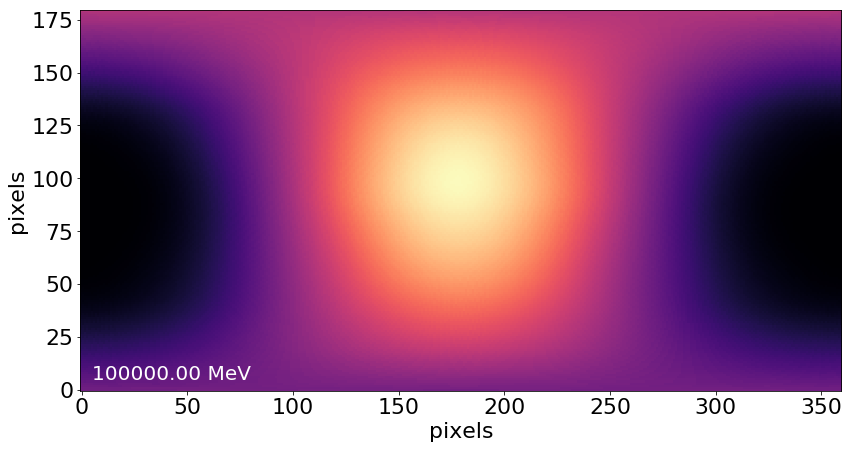

In [36]:
f, ax = plt.subplots(figsize=(16, 7))
for i, expcube in enumerate(expcube_hdu[0].data):
    time.sleep(0.2)
    plt.imshow(expcube,
           cmap='magma',origin='lower',
           vmin=expcube_hdu[0].data.min(), 
           vmax=expcube_hdu[0].data.max())
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    label =  "{:.2f} MeV".format(expcube_hdu[1].data['Energy'][i])
    plt.text(5,5,label,fontsize=20, color='white')
    
    clear_output(wait=True)
    display(f)
    ax.cla()
    
plt.close()


Model
====================
### We Have:
* Observational response (“exposure”)
    * Observational profile
    * Instrument response functions (IRFs)
    
   
### We Need
* Sky model
    * Spatial distribution of sources in ROI (point-like and extended sources)
    * Spectral model for each source


Sky Model
===================
* Spatial and spectral model
* Point sources	(coordinates: RA & Dec)
* Extended sources	(map of emission)
* Diffuse sources	(full sky maps)
* Spectral types	(e.g. power law - index, flux)
* No time dependence!
* All these encoded in an XML input file
    * ST and LAT catalogs can help with this task 

Model for our Sample ROI
=============================
* Sources from a catalog in and near the ROI
    * Best-fit locations and spectral types (over some time period)
* Diffuse isotropic
    * Extragalactic diffuse gamma rays
    * Local cosmic ray background
* Galactic diffuse
    * Cosmic ray interactions
* Local sources of gamma rays: Earth limb, also the Sun and Moon 

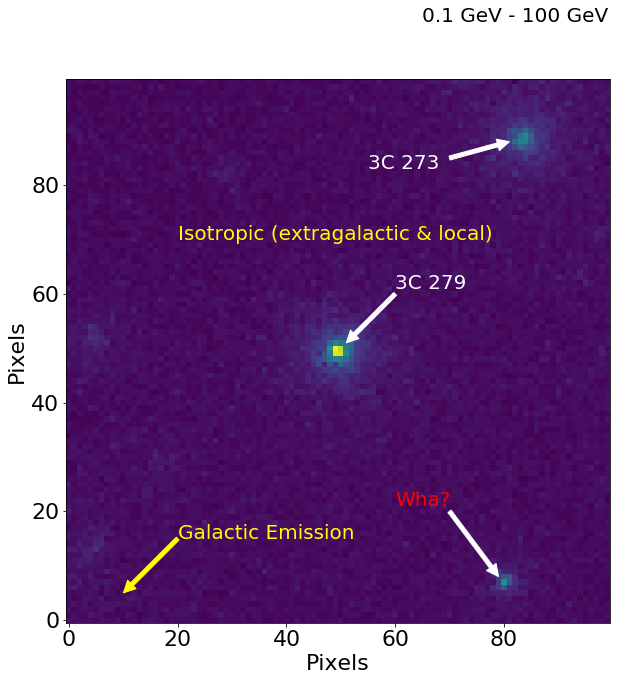

In [37]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(cmap_hdu[0].data,origin='lower')

aprops = {'facecolor':'white','edgecolor':'white'}

plt.annotate('', xy=(79, 8), xycoords = 'data',
             xytext = (70, 20), textcoords = 'data',
             arrowprops = aprops)
plt.text(60, 21, 'Wha?',fontsize=20,color='red')


plt.annotate('', xy=(51,51), xycoords = 'data',
            xytext = (60,60), textcoords = 'data',
            arrowprops = aprops)
plt.text(60, 61, '3C 279',fontsize=20,color='white')

plt.annotate('', xy=(81,88), xycoords = 'data',
            xytext = (70,85), textcoords = 'data',
            arrowprops = aprops)
plt.text(55, 83, '3C 273',fontsize=20,color='white')

plt.annotate('', xy=(10,5), xycoords = 'data',
            xytext = (20,15), textcoords = 'data',
            arrowprops = {'facecolor':'yellow','edgecolor':'yellow'})
plt.text(20, 15, 'Galactic Emission',fontsize=20,color='yellow')

plt.text(20, 70, 'Isotropic (extragalactic & local)',fontsize=20,color='yellow')

plt.text(65,110,"0.1 GeV - 100 GeV",fontsize=20)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

Model for our Sample ROI
===============================

* Point Sources: $$S(E,\hat{p},t) = \sum_i s_i(E,t)\delta(\hat{p}-\hat{p}_i)$$
* Galactic Diffuse: $$+ S_G(E,\hat{p})$$ 
* Extragalactic and Residual: $$+ S_{eg}(E,\hat{p})$$ 
* Other Extended Sources (Optional): $$+ \sum_l S_l(E,\hat{p},t)$$ 

Example for a power law spectral model
---------------------------------

$$S(E,\hat{p},t) = S(E,F_0,\Gamma,E_0) = F_0(\frac{E}{E_0})^{-\Gamma}$$


We now have everyhitng we need to perform the maximum likelihood optimization.  We have the photons, we have the exposure but we don't have a model.  We'll talk about how to build this model in a bit but for now, I'm giving you a sample model definition for the purposes of this analysis.  Here's what the file looks like:

    <?xml version="1.0" ?>
    <source_library title="source library" xmlns="http://fermi.gsfc.nasa.gov/source_library">

    <source name="iso_source_v05.txt" type="DiffuseSource">
        <spectrum file="../data/iso_source_v05.txt" type="FileFunction">
            <parameter free="1" max="1000" min="1e-05" name="Normalization" scale="1" value="1" />
        </spectrum>
        <spatialModel type="ConstantValue">
            <parameter free="0" max="10.0" min="0.0" name="Value" scale="1.0" value="1.0"/>
        </spatialModel>
    </source>

    <source name="gll_iem_v06.fits" type="DiffuseSource">
        <spectrum type="PowerLaw">
          <parameter free="0" max="1.0" min="-1.0" name="Index" scale="-1.0" value="0.0"/>
          <parameter free="0" max="1000.0" min="1000.0" name="Scale" scale="1.0" value="1000.0"/>
          <parameter free="0" max="10.0" min="0.1" name="Prefactor" scale="1.0" value="1.0"/>
        </spectrum>
        <spatialModel file="../data/gll_iem_v06.fits" type="MapCubeFunction">
            <parameter free="0" max="1000.0" min="0.001" name="Normalization" scale= "1.0" value="1.0"/>
        </spatialModel>
    </source>

    <source name="3C 273" type="PointSource">
        <spectrum type="PowerLaw">
            <parameter free="1" max="1000.0" min="0.001" name="Prefactor" scale="1e-09" value="10"/>
            <parameter free="1" max="-1.0" min="-5.0" name="Index" scale="1.0" value="-2.1"/>
            <parameter free="0" max="2000.0" min="30.0" name="Scale" scale="1.0" value="100.0"/>
        </spectrum>
        <spatialModel type="SkyDirFunction">
            <parameter free="0" max="360" min="-360" name="RA" scale="1.0" value="187.25"/>
            <parameter free="0" max="90" min="-90" name="DEC" scale="1.0" value="2.17"/>
        </spatialModel>
    </source>

    <source name="3C 279" type="PointSource">
        <spectrum type="PowerLaw">
            <parameter free="1" max="1000.0" min="0.001" name="Prefactor" scale="1e-09" value="10"/>
            <parameter free="1" max="-1.0" min="-5.0" name="Index" scale="1.0" value="-2"/>
            <parameter free="0" max="2000.0" min="30.0" name="Scale" scale="1.0" value="100.0"/>
        </spectrum>
        <spatialModel type="SkyDirFunction">
            <parameter free="0" max="360" min="-360" name="RA" scale="1.0" value="193.98"/>
            <parameter free="0" max="90" min="-90" name="DEC" scale="1.0" value="-5.82"/>
        </spatialModel>
    </source>

    </source_library>

The model file is stored in a format called eXtensible Markup Language (XML) which is just a set of rules to encode information in a text file.  The model file is our description of what we think the region should look like.  You'll hear more about how to create these files later.

You can download this file: [3C_279_input_model.xml](https://raw.github.com/kialio/fermi-summer-school/master/3C279_input_model.xml)

Notice that the model file makes refernce to two files, [iso_P8R2_SOURCE_V6_v06.txt](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/aux/iso_P8R2_SOURCE_V6_v06.txt) and [gll_iem_v06.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/aux/gll_iem_v06.fits).  These two files describe the extragalactic and galactic diffuse emission respectively. You'll need to download them and put them in your data directory. We'll be using these over and over again throughout the week and it's good to keep them in a standard location.

In [47]:
ls ../data

3C279_ccube.fits    3C279_filtered.fits  events.txt                   old/
3C279_cmap.fits     3C279_ltcube.fits    gll_iem_v06.fits@            PH00.fits
3C279_expcube.fits  3C279_mktime.fits    iso_P8R2_SOURCE_V6_v06.txt@  SC00.fits










Notice that these are suspiciously named like they might depend on the event class you're using.  You would be right to assume so.  Let's take a look at these.  The isotropic diffuse model is just a text file:

In [40]:
import numpy as np

In [41]:
isotropic = np.genfromtxt("../data/iso_P8R2_SOURCE_V6_v06.txt")

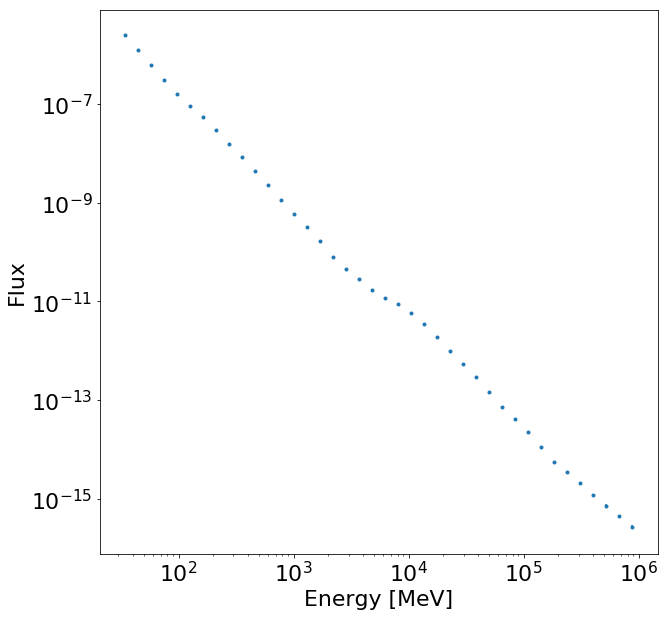

In [42]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.xscale('log')
plt.errorbar(isotropic[:,0],isotropic[:,1],yerr=isotropic[:,2],fmt='.')
plt.xlabel('Energy [MeV]')
plt.ylabel('Flux')
plt.show()

The isotropic model is spatially isotropic but is energy dependent.  Open up the galactic diffuse:

In [43]:
gal_diff = pyfits.open("../data/gll_iem_v06.fits")

In [44]:
gal_diff.info()

Filename: ../data/gll_iem_v06.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (2880, 1441, 30)   float32   
  1  ENERGIES      1 BinTableHDU     11   30R x 1C   [D]   


In [45]:
from matplotlib.colors import LogNorm

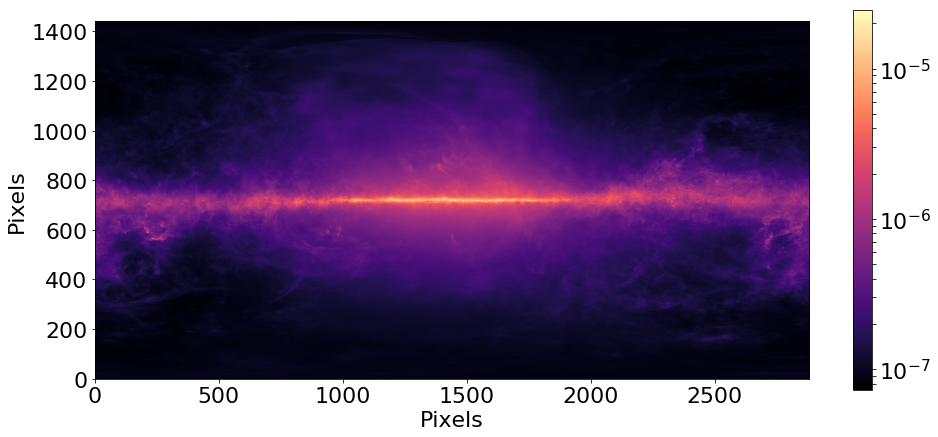

In [46]:
plt.figure(figsize=(16,7))
plt.imshow(gal_diff[0].data[0],cmap='magma',norm=LogNorm(),origin='lower')
plt.colorbar()
plt.ylabel('Pixels')
plt.xlabel('Pixels')
plt.show()

The model for the Galactic diffuse emission was developed using spectral line surveys of HI and CO (as a tracer of H2) to derive the distribution of interstellar gas in Galactocentric rings. Infrared tracers of dust column density were used to correct column densities in directions where the optical depth of HI was either over or under-estimated. The model of the diffuse gamma-ray emission was then constructed by fitting the gamma-ray emissivities of the rings in several energy bands to the LAT observations. The fitting also required a model of the inverse Compton emission calculated using GALPROP and a model for the isotropic diffuse emission. [A complete description of the Galactic diffuse model is available](http://iopscience.iop.org/article/10.3847/0067-0049/223/2/26).

## Compute the souce maps

These are model counts maps for all of the sources in our model assuming our esposure, response, and spectral models.

This takes a while so let get it going and then talk about what's next.



In [48]:
from gt_apps import srcMaps

In [49]:
srcMaps['expcube'] = '../data/3C279_ltcube.fits'
srcMaps['cmap'] = '../data/3C279_ccube.fits'
srcMaps['srcmdl'] = '3C279_input_model.xml'
srcMaps['bexpmap'] = '../data/3C279_expcube.fits'
srcMaps['outfile'] = '../data/3C279_srcmaps.fits'

In [50]:
srcMaps.run()

time -p /home/fermi/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/bin/gtsrcmaps scfile= sctable="SC_DATA" expcube=../data/3C279_ltcube.fits cmap=../data/3C279_ccube.fits srcmdl=3C279_input_model.xml bexpmap=../data/3C279_expcube.fits wmap=none outfile=../data/3C279_srcmaps.fits irfs="CALDB" evtype="INDEF" convol=yes resample=yes rfactor=2 minbinsz=0.1 ptsrc=yes psfcorr=yes emapbnds=yes copyall=no chatter=2 clobber=yes debug=no gui=no mode="ql"
Generating SourceMap for 3C 273....................!
Generating SourceMap for 3C 279....................!
Generating SourceMap for gll_iem_v06....................!
Generating SourceMap for iso_P8R2_SOURCE_V6_v06....................!
real 78.20
user 70.62
sys 3.44


The Summary of what we've done and where we are going
-------------------------------------------

* We observed a photon from a location with a specific energy
* We assume a model:
$$S(E,\hat{p}) = \sum_i s_i(E)\delta(\hat{p}-\hat{p}_i)
                        + S_G(E,\hat{p}) + S_{eg}(E,\hat{p})
                        + \sum_l S_l(E,\hat{p})$$
* The model is defined as 
    * a summation over point sources,
    * the galactic and extra-galactic diffuse
    * and a summataion over anything else.
* We bin these photons into channels of energy and position:
    $$(E_i, \hat{p}_i)$$
of size
$$\Delta E_i\Delta\hat{p}_i : n_i$$
* We calculate the probability of that photon being detected assuming our model (Poissonian mean):

$$\lambda_i(S) = \Delta E_i\Delta\hat{p}_i \int dE \int_{ROI+} d\hat{p}
 S(E, \hat{p}) R(E_i, \hat{p}_i, E, \hat{p})$$
$$= \Delta E_i\Delta\hat{p}_i \int_{ROI+} d\hat{p}
 S(E_i, \hat{p}) R(E_i, \hat{p}_i, \hat{p})$$


* Then we calculate the total number of predicted counts assuming our model:

$$N_{pred} = \sum_i \lambda_i(S)$$


* We can precompute some of the values in the integral.  Namely $S(E_i, \hat{p}) R(E_i, \hat{p}_i, \hat{p})$ in such a way that we can still adjust it as needed (so compute generic source templates convolved with the response - the Source Map).

* The Log likelihood is 

$$ln\mathcal{L}(S) = \sum_{i\in Bins} n_i \ln \lambda_i(S) - N_{pred}(S)$$

* We adjust the model (S) until this is maximized (or minimized)

* And we calculate the TS

$$TS = -2 \log \frac{L_{max,0}}{L_{max,1}}$$

The Optimization
====================

I think we're ready to go now.  We're going to do this the python way (you could use *gtlike* if you wish).

In [51]:
from BinnedAnalysis import *

First, create an obsevation object which describes your observation.

In [52]:
obs = BinnedObs(srcMaps='../data/3C279_srcmaps.fits',
                expCube='../data/3C279_ltcube.fits',
                binnedExpMap='../data/3C279_expcube.fits',
                irfs='CALDB')

Now, create an analysis object.

In [53]:
analysis = BinnedAnalysis(obs,srcModel='3C279_input_model.xml', optimizer='MINUIT')

Note that we selected an *optimizer*.  There are a couple of options (see the help file for gtlike) but most of the time you'll using one of the MINUIT optimizers (NEWMINUIT or MINUIT).  Now, we're ready to do the actual fit, but we can check out the objects we just created if we want.

In [54]:
analysis.tol

0.001

In [55]:
analysis.fit?

There are lots of other variables and functions associated with these but we'll leave that to the advanced likelihood lecture tomorrow.  For now, lets do the fit.

In [56]:
analysis.fit()

75288.36763346891

The number returned is the log(Likelihood) of the full fit.  You should also see a lot of information printed to the terminal.  You can even get this number later:

In [57]:
analysis.logLike.value()

-75288.36763346891

So, that's all and good, how do I get at the results of the fit?

Well, you can look at the model this way:

In [58]:
analysis.model

3C 273
   Spectrum: PowerLaw
0      Prefactor:  1.293e+01  3.252e-01  1.000e-03  1.000e+03 ( 1.000e-09)
1          Index: -2.735e+00  2.102e-02 -5.000e+00 -1.000e+00 ( 1.000e+00)
2          Scale:  1.000e+02  0.000e+00  3.000e+01  2.000e+03 ( 1.000e+00) fixed

3C 279
   Spectrum: PowerLaw
3      Prefactor:  1.152e+01  2.472e-01  1.000e-03  1.000e+03 ( 1.000e-09)
4          Index: -2.348e+00  1.393e-02 -5.000e+00 -1.000e+00 ( 1.000e+00)
5          Scale:  1.000e+02  0.000e+00  3.000e+01  2.000e+03 ( 1.000e+00) fixed

gll_iem_v06
   Spectrum: PowerLaw
6      Prefactor:  1.000e+00  0.000e+00  1.000e-01  1.000e+01 ( 1.000e+00) fixed
7          Index:  0.000e+00  0.000e+00 -1.000e+00  1.000e+00 (-1.000e+00) fixed
8          Scale:  1.000e+03  0.000e+00  1.000e+03  1.000e+03 ( 1.000e+00) fixed

iso_P8R2_SOURCE_V6_v06
   Spectrum: FileFunction
9     Normalization:  1.000e+00  0.000e+00  1.000e-05  1.000e+03 ( 1.000e+00) fixed

In [59]:
analysis.thaw(6)
analysis.thaw(9)

In [60]:
analysis.fit()

73807.88869468783

In [61]:
analysis.model

3C 273
   Spectrum: PowerLaw
0      Prefactor:  1.018e+01  3.071e-01  1.000e-03  1.000e+03 ( 1.000e-09)
1          Index: -2.675e+00  2.312e-02 -5.000e+00 -1.000e+00 ( 1.000e+00)
2          Scale:  1.000e+02  0.000e+00  3.000e+01  2.000e+03 ( 1.000e+00) fixed

3C 279
   Spectrum: PowerLaw
3      Prefactor:  8.099e+00  2.166e-01  1.000e-03  1.000e+03 ( 1.000e-09)
4          Index: -2.235e+00  1.511e-02 -5.000e+00 -1.000e+00 ( 1.000e+00)
5          Scale:  1.000e+02  0.000e+00  3.000e+01  2.000e+03 ( 1.000e+00) fixed

gll_iem_v06
   Spectrum: PowerLaw
6      Prefactor:  1.277e+00  2.721e-02  1.000e-01  1.000e+01 ( 1.000e+00)
7          Index:  0.000e+00  0.000e+00 -1.000e+00  1.000e+00 (-1.000e+00) fixed
8          Scale:  1.000e+03  0.000e+00  1.000e+03  1.000e+03 ( 1.000e+00) fixed

iso_P8R2_SOURCE_V6_v06
   Spectrum: FileFunction
9     Normalization:  1.428e+00  3.463e-02  1.000e-05  1.000e+03 ( 1.000e+00)

You can also get at the test statistic of a specific source

In [62]:
analysis.Ts('3C 279')

12695.988166032388

and the number of predicted counts

In [63]:
analysis.NpredValue('3C 279')

7644.388802557994

You can plot a counts spectrum in python:

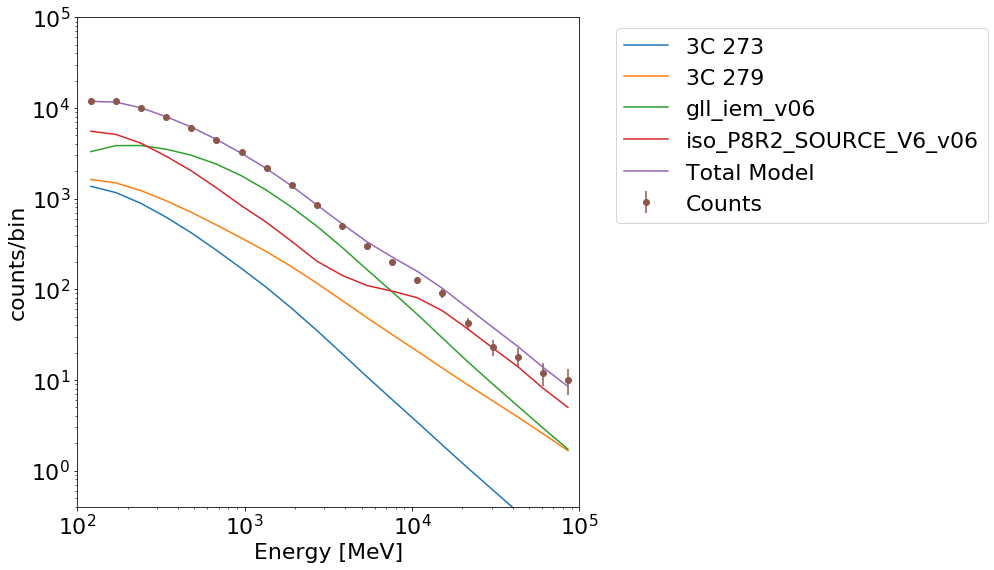

In [64]:
E = (analysis.energies[:-1] + analysis.energies[1:])/2.
#The 'energies' array are the endpoints so we take the midpoint of the bins.
plt.figure(figsize=(9,9))
plt.ylim((0.4,1e5))
plt.xlim((100,100000))
sum_model = np.zeros_like(analysis._srcCnts(analysis.sourceNames()[0]))
for sourceName in analysis.sourceNames():
    sum_model = sum_model + analysis._srcCnts(sourceName)
    plt.loglog(E,analysis._srcCnts(sourceName),label=sourceName)
plt.loglog(E,sum_model,label='Total Model')
plt.errorbar(E,analysis.nobs,yerr=np.sqrt(analysis.nobs), fmt='o',label='Counts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylabel('counts/bin')
plt.xlabel('Energy [MeV]')
plt.show()

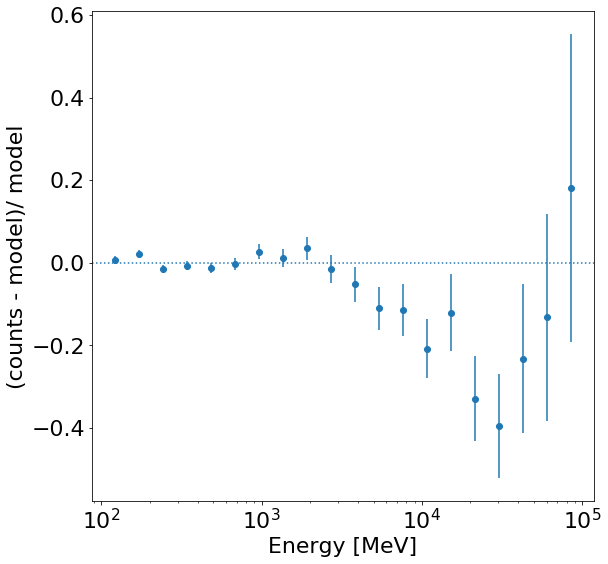

In [65]:
resid = (analysis.nobs - sum_model)/sum_model
resid_err = (np.sqrt(analysis.nobs)/sum_model)
plt.figure(figsize=(9,9))
plt.xscale('log')
plt.errorbar(E,resid,yerr=resid_err,fmt='o')
plt.axhline(0.0,ls=':')
plt.xlabel('Energy [MeV]')
plt.ylabel('(counts - model)/ model')
plt.show()

You can output a new XML model:

In [66]:
analysis.writeXml('3C279_output_model.xml')

You can get at the integral flux of a specific source:

In [67]:
print "3C 279 Integral Flux = {} +- {}".format(analysis.flux('3C 279'), analysis.fluxError('3C 279'))

RuntimeError: Covariance matrix has not been computed.

Oops.  Forgot to do that.  What's the covariance matrix?  It's basically the matrix of values that shows how each variable in your model depends on each other variable.  We can tell the fit to compute that.

In [68]:
analysis.fit(covar=True)

73807.8886931731

In [69]:
print "3C 279 Integral Flux = {} +- {}".format(analysis.flux('3C 279'), analysis.fluxError('3C 279'))

3C 279 Integral Flux = 6.56463570945e-07 +- 1.20244907913e-08


"Binned" or "Unbinned" (or both)?
=================================
* We did a binned analysis here.
* Binned - _recommended for most analysis by LAT collaboration_
    * Faster for large data sets (averaged IRFs)
    * Diffuse source calculation simpler
* Unbinned - _useful in certain circumstances_
    * Slow for large data sets (IRF for each event)
    * Diffuse source calculation very slow (but can be pre-calculated)
    * TS values may be higher than binned analysis if choice of bin size dilutes photon information
* Mixed - “Composite Likelihood”
    * Advanced - You can have your cake and eat it, too! For example, you can use binned at lower energy where the PSF is broad and photons are numerous and switch to unbinned at higher energy where photons are more sparse in energy and position. But in most cases this is not necessary.


### What About?...

Over the next two weeks we'll go over the advanced likelihood and talk about things like

* Upper Limits
* Composite and Summed Likelihood
* Scripting
* Muliti-Core Processing
* User Contributed Tools
* Fit verification
* …and more